# Additional analyses on patients transfusions and cross-matches
The goal of the notebook is twofold: (1) correlate positive cross-matches with patients' trajectories and (2) analyze the effect of blood transfusion on the number of crossings/amplitude of the MFI change.

### Positive cross-matches


In [1]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

In [2]:
# Start by loading the cross-match information as well as patients values
df_crossmatches = pd.read_excel('data/original_datasets/Cross match RS number Matteo.xlsx', encoding='latin', header=2)

In [3]:
# Transform the dataframe
df_crossmatches_filtered = df_crossmatches.drop(columns=['Parameter'])
df_crossmatches_filtered = df_crossmatches_filtered[2:]
df_crossmatches_filtered = df_crossmatches_filtered.set_index('RS number')

In [4]:
print(f'There are {df_crossmatches_filtered.isna().any(axis=1).sum()} NaNs')

# save the processed file
df_crossmatches_filtered.to_csv('data/crossmatches_filtered.csv')

There are 0 NaNs


In [5]:
# Count positive cross-matches.
df_positive_cross = df_crossmatches_filtered=='pos'
print(f'In total there are {df_positive_cross.any(axis=1).sum()} patients with at least one positive crossmatch.')

In total there are 24 patients with at least one positive crossmatch.


In [6]:
# Cross reference those files with patients kept in the study
# Loading filtered dataset
filename = 'data/MFI_with_RS_new_filtering.csv'
df_filtered = pd.read_csv(filename, encoding = "latin").set_index('RSNR', drop=False)

In [7]:
positive_crossing_patients = set(df_positive_cross.index[df_positive_cross.any(axis=1)])

all_patients = set(df_filtered.index)
positive_crossing_patients_in_study = positive_crossing_patients.intersection(all_patients)
print(f"There are {len(positive_crossing_patients_in_study)} \
    patients with positive crossmatch IN THE STUDY.")

There are 21     patients with positive crossmatch IN THE STUDY.


In [11]:
print(df_crossmatches_filtered.loc[list(positive_crossing_patients_in_study)].to_string(index=False))

T-Zell CDC-XM B-Zell CDC-XM T-Zell XM ohne DTT B-Zell XM Ohne DTT
                                                                
         neg           neg                neg                pos
         neg           neg                neg                pos
         neg           pos                neg                pos
         neg           neg                neg                pos
         neg           pos                neg                pos
         neg           neg                pos                neg
         neg           neg                neg                pos
         neg           neg                neg                pos
         neg           neg                neg                pos
         neg           pos                neg                pos
         neg           neg                neg                pos
         neg           neg                pos                pos
         neg           pos                neg                pos
         neg           n

In [12]:
# Not all these are interesting, we can only keep the ones which are positive even with DTT.
true_positive_patients_ids = df_crossmatches_filtered[np.logical_or(df_crossmatches_filtered['T-Zell CDC-XM']=='pos',
                                      df_crossmatches_filtered['B-Zell CDC-XM']=='pos')].index

In [13]:
true_positive_crossing_patients_in_study = true_positive_patients_ids.intersection(all_patients)
print(f"There are {len(true_positive_crossing_patients_in_study)} \
    patients with positive crossmatch IN THE STUDY.")

There are 4     patients with positive crossmatch IN THE STUDY.


In [15]:
# Loading filtered dataset
filename = 'data/MFI_with_RS_new_filtering.csv'
df_filtered = pd.read_csv(filename, encoding = "latin").set_index('RSNR', drop=False)

In [16]:
# We need to standardize the way in which we compile the time series of each patient:
# For missing Abs, we should add a 499,499,... or a NaN,NaN,... time series
ALL_ABS_TYP1 = df_filtered[df_filtered['TYP']=='Lumi-Single-Klasse1']['I_NAM'].unique()
ALL_ABS_TYP2 = df_filtered[df_filtered['TYP']=='Lumi-Single-Klasse2']['I_NAM'].unique()
ALL_ABS = df_filtered['I_NAM'].unique()

from utils import get_evolution_df, get_time_series, filter_patients

In [17]:
df_filtered_typ1 = filter_patients(df_filtered)
df_filtered_typ1['RSNR'].nunique()

17 patients need to be excluded as they only have one date of measurements.


/Volumes/tomatteo$/Projects/HLAvariability/utils.py:39: FutureWarning: 'RSNR' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  df_n = df_filtered_typ.groupby('RSNR')['IL_DAT'].nunique()
/Volumes/tomatteo$/Projects/HLAvariability/utils.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered_typ = df_filtered_typ.set_index('RSNR', drop=False)[df_n>1]


438

In [18]:
# Let's rather look at the mean values.
# We get the peak values matrix
AB_list = sorted(list(df_filtered['I_NAM'].unique().astype(str)))[:-1] # remove the nan column
# Need to invert DP and DR for plotting
AB_list = AB_list[:80] + AB_list[105:] + AB_list[98:105] + AB_list[80:98]
# The get all patient (we will only use patient with multiple measurements)
patient_list = sorted(list(df_filtered.index.unique()))
# For each patient extract the maximum values (and fill missing entries with 0)
DEFAULT_VALUE = 499
value_matrix = []
for patient in patient_list:
    values = df_filtered[df_filtered.index==patient].groupby('I_NAM').max()['I_VAL']
    complete_values = []
    for ab in AB_list:
        # try to get the value
        val = values.get(ab)
        if val and val!=np.nan:
            complete_values.append(val)
        else:
            complete_values.append(DEFAULT_VALUE)
    value_matrix.append(complete_values)
peak_values = np.asarray(value_matrix)

In [19]:
df_peak = pd.DataFrame(peak_values, index=patient_list, columns=AB_list)
# THere are 2 Nans:
df_peak[df_peak.isnull()] = DEFAULT_VALUE

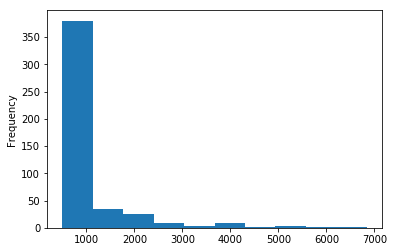

In [20]:
df_peak.mean(axis=1).plot(kind='hist')

In [21]:
for rs in true_positive_crossing_patients_in_study:
#     print(rs)
    print('Mean value: ' + str(df_peak.mean(axis=1)[rs]))
    print('Max value: ' + str(df_peak.max(axis=1)[rs]))
    print()

Mean value: 3761.569105691057
Max value: 13861.0

Mean value: 4126.788617886179
Max value: 14500.0

Mean value: 3172.5040650406504
Max value: 22170.0

Mean value: 513.8617886178862
Max value: 1874.0



In [22]:
df_peak.mean().mean()

934.3964831740393

## Looking at blood transfusions instead

In [23]:
# First, single out patients with blood transfusion dates
# Control for immunizing events
# Load the list of transfusions
filename = "./data/Transfusions_data_RS_nummer.csv"
df_immunizing = pd.read_csv(filename, encoding='latin')

In [24]:
df_map = pd.read_csv("data/RS_nummer_age_sex.csv",index_col=0)
# List of patients, get gender
all_patids = list(df_map.index.unique())

# Start by cleaning off the data: RSNR remove asterisks
# Remove lines without RSNR
df_immunizing = df_immunizing[df_immunizing["RSNR"].notnull()]
# Remove asterisks
new_RSNR = []
for rn in df_immunizing['RSNR']:
    if rn[:2] == "**":
        new_RSNR.append(rn[2:-2])
    else:
        new_RSNR.append(rn)

df_immunizing.loc[:,'RSNR'] = new_RSNR

# Now filter and only keep RSNR of interest (i.e. that we kept in the analysis thus far.)
df_immunizing_filtered = df_immunizing[[d in all_patids for d in df_immunizing["RSNR"]]]

In [25]:
# Only keep patients with transfusions
df_transfused = df_immunizing_filtered[df_immunizing_filtered['TRFLIST'] != 'keine']

In [26]:
# First, remove the unknown.
df_transfused = df_transfused[~np.logical_or(np.logical_or(df_transfused['TRFLIST']=='1: unbekannt EC', 
                                                         df_transfused['TRFLIST']=='1: ? EC'),
                                             df_transfused['TRFLIST']=='1: unbekannt')]
df_transfused = df_transfused[~df_transfused['TRFLIST'].isna()]

In [27]:
# Cross reference those files with patients kept in the study
# Loading filtered dataset
filename = 'data/MFI_with_RS_new_filtering.csv'
df_filtered = pd.read_csv(filename, encoding = "latin").set_index('RSNR', drop=False)

In [28]:
rs_id_transfused = set(df_transfused['RSNR']).intersection(set(df_filtered.index))
print('There are {} patients with transfusion information, {} of these in our studied dataset.'.format(
        len(df_transfused), len(rs_id_transfused)))

There are 192 patients with transfusion information, 152 of these in our studied dataset.


In [29]:
df_transfused_filtered = df_transfused.set_index('RSNR', drop=False)
df_transfused_filtered = df_transfused_filtered.loc[list(rs_id_transfused)]

In [30]:
df_transfused_filtered.index.nunique()

152

In [31]:
# Need to filter further
# add a regex for the dates
import re
prog = re.compile('\d{2}(\.|-)\d{2}(\.|-)\d{4}')

# create a dictionary with the dates for each patient.
transfusion_dates = dict()
for i, row in df_transfused_filtered.iterrows():
    transfusion_dates[i] = [j.group(0) for j in prog.finditer(row['TRFLIST'])]

In [32]:
# Get rid of patients with imprecise dates.
transfusion_dates_new = dict()
for k in list(transfusion_dates.keys()):
    if transfusion_dates[k]:
        transfusion_dates_new[k] = transfusion_dates[k]
        
print('After filtering, there are {} patients left (out of {})'.format(len(transfusion_dates_new),
                                                                       len(transfusion_dates)))

After filtering, there are 91 patients left (out of 152)


In [33]:
c = 0
for k in list(transfusion_dates_new.keys()):
    c+=len(transfusion_dates_new[k])
    print('RS-XXX' + ' : ' + str(len(transfusion_dates_new[k])))

RS-XXX : 1
RS-XXX : 4
RS-XXX : 1
RS-XXX : 2
RS-XXX : 1
RS-XXX : 2
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 2
RS-XXX : 1
RS-XXX : 1
RS-XXX : 2
RS-XXX : 2
RS-XXX : 2
RS-XXX : 2
RS-XXX : 3
RS-XXX : 1
RS-XXX : 1
RS-XXX : 9
RS-XXX : 1
RS-XXX : 1
RS-XXX : 7
RS-XXX : 2
RS-XXX : 3
RS-XXX : 2
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 4
RS-XXX : 3
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 2
RS-XXX : 1
RS-XXX : 4
RS-XXX : 2
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 3
RS-XXX : 3
RS-XXX : 1
RS-XXX : 2
RS-XXX : 2
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 2
RS-XXX : 4
RS-XXX : 1
RS-XXX : 2
RS-XXX : 6
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 5
RS-XXX : 1
RS-XXX : 1
RS-XXX : 2
RS-XXX : 1
RS-XXX : 1
RS-XXX : 2
RS-XXX : 2
RS-XXX : 1
RS-XXX : 2
RS-XXX : 1
RS-XXX : 2
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1
RS-XXX : 1

In [34]:
print(c)

156


In [35]:
# Transform to datetime
import datetime
for k in list(transfusion_dates_new.keys()):
    transfusion_dates_new[k] = [datetime.datetime.strptime(x, '%d.%m.%Y') for x in transfusion_dates_new[k]]

In [36]:
# Now, need to look at closest measurement for every patient.
# Load the MFI values
from utils import get_evolution_df, get_time_series, filter_patients

ALL_ABS_TYP1 = df_filtered[df_filtered['TYP']=='Lumi-Single-Klasse1']['I_NAM'].unique()
ALL_ABS_TYP2 = df_filtered[df_filtered['TYP']=='Lumi-Single-Klasse2']['I_NAM'].unique()
ALL_ABS = df_filtered['I_NAM'].unique()

df_filtered_typ1 = filter_patients(df_filtered)
df_filtered_typ2 = filter_patients(df_filtered, analysis_type='2')
df_filtered_typ1['RSNR'].nunique()

17 patients need to be excluded as they only have one date of measurements.
20 patients need to be excluded as they only have one date of measurements.


/Volumes/tomatteo$/Projects/HLAvariability/utils.py:39: FutureWarning: 'RSNR' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  df_n = df_filtered_typ.groupby('RSNR')['IL_DAT'].nunique()
/Volumes/tomatteo$/Projects/HLAvariability/utils.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered_typ = df_filtered_typ.set_index('RSNR', drop=False)[df_n>1]
/Volumes/tomatteo$/Projects/HLAvariability/utils.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered_typ = df_filtered_typ.set_index('RSNR', drop=False)[df_n>1]


438

In [37]:
# For each transfusion date: 
# 1. find next nearest measurements.
# 2. Correlate time-to-meas with average signal
# 3. Correlate time-to-meas with mean diff in signal

# Gather the signal differences and average them for all single measurements
tdifs = []
valdifs = []
kept_ids = []
timeseries = []
for patid in df_filtered_typ1['RSNR'].unique():
    try: # Skip patients that show issues
        patient_ts = get_evolution_df(df_filtered_typ1.loc[patid], complete=True, analysis_type='1')
        # Get the tdif array, we use days as seconds will lead to too small values upon division
        kept_ids.append(patid)
        timeseries.append(patient_ts)
    except:
        continue

In [38]:
# Let's build the table
mean_val = dict()
mean_val_change = dict()
from datetime import timedelta

values = [] # contain all entries with date, delta to next measurement, mean MFI value, max MFI value, 
            # mean MFI change, largest diff
def add_values(values, kept_ids, timeseries, class_type='Type 1'):
    for i, rs in enumerate(kept_ids):
        if rs in list(transfusion_dates_new.keys()):
            print(i)
#             print(rs)
            for d in sorted(transfusion_dates_new[rs]):
                print("Transfusion date: {}".format(d))
                # Skip if the transfusion date is too old:
                if d < datetime.datetime(1995,1,1):
                    print("Date is too old, skipping.")
                    values.append([d, None, None, None, None, None, class_type, rs, i])
                    continue

                # Skip if there are no subsequent dates.
                if (d > timeseries[i].index).all():
                    print("No subsequent dates.")
                    values.append([d, None, None, None, None, None, class_type, rs, i])
                    continue

                # Find following date
                def func(bd):
                    delta = 0
                    delta =  bd - d if bd > d else timedelta.max
                    return delta
                next_date = min(timeseries[i].index[d <= timeseries[i].index], key = func)
                print("Following date: {}".format(next_date))

                # Get mean and max MFI
                mean_mfi = timeseries[i].loc[next_date].mean()
                max_mfi = timeseries[i].loc[next_date].max()

                dates = sorted(timeseries[i].index.tolist())
                index_next_date = dates.index(next_date)
                prev_date = dates[index_next_date-1] if index_next_date>0 else None

                if prev_date:
                    print("Previous date: {}".format(prev_date))
                    x = timeseries[i].loc[next_date] - timeseries[i].loc[prev_date]
                    mean_abs_mfi_change = np.abs(x).T.mean(axis=0)
                    max_abs_mfi_change = np.abs(x).T.max(axis=0)
                    values.append([d, (next_date-d).days, mean_mfi, max_mfi, 
                                   mean_abs_mfi_change, max_abs_mfi_change, class_type, rs, i])
                else:
                    print("No previous date.")
                    values.append([d, (next_date-d).days, mean_mfi, max_mfi, 
                                   None, None, class_type, rs, i])
                # Get previous date

            print()
    return values

In [39]:
values = add_values([], kept_ids, timeseries, class_type='Type 1')

7
Transfusion date: 2014-04-11 00:00:00
No subsequent dates.

9
Transfusion date: 2013-10-03 00:00:00
No subsequent dates.
Transfusion date: 2013-10-06 00:00:00
No subsequent dates.

14
Transfusion date: 2012-06-08 00:00:00
Following date: 2013-02-13 00:00:00
No previous date.
Transfusion date: 2012-06-25 00:00:00
Following date: 2013-02-13 00:00:00
No previous date.
Transfusion date: 2012-08-08 00:00:00
Following date: 2013-02-13 00:00:00
No previous date.

16
Transfusion date: 2015-07-15 00:00:00
No subsequent dates.

17
Transfusion date: 2011-07-08 00:00:00
Following date: 2011-08-08 00:00:00
No previous date.

22
Transfusion date: 2014-02-10 00:00:00
Following date: 2014-07-23 00:00:00
Previous date: 2014-01-13 00:00:00

24
Transfusion date: 2013-11-29 00:00:00
Following date: 2013-12-12 00:00:00
Previous date: 2013-04-29 00:00:00
Transfusion date: 2013-12-04 00:00:00
Following date: 2013-12-12 00:00:00
Previous date: 2013-04-29 00:00:00

29
Transfusion date: 2013-12-23 00:00:00
No

In [40]:
# Add class2 measurements
# Gather the signal differences and average them for all single measurements
kept_ids_2 = []
timeseries_2 = []
for patid in df_filtered_typ2['RSNR'].unique():
    try: # Skip patients that show issues
        patient_ts = get_evolution_df(df_filtered_typ2.loc[patid], complete=True, analysis_type='2')
        kept_ids_2.append(patid)
        timeseries_2.append(patient_ts)
    except:
        continue

In [41]:
values = add_values(values, kept_ids_2, timeseries_2, class_type='Type 2')

7
Transfusion date: 2014-04-11 00:00:00
No subsequent dates.

13
Transfusion date: 2012-06-08 00:00:00
Following date: 2013-02-13 00:00:00
No previous date.
Transfusion date: 2012-06-25 00:00:00
Following date: 2013-02-13 00:00:00
No previous date.
Transfusion date: 2012-08-08 00:00:00
Following date: 2013-02-13 00:00:00
No previous date.

14
Transfusion date: 2015-07-15 00:00:00
No subsequent dates.

15
Transfusion date: 2011-07-08 00:00:00
Following date: 2011-08-08 00:00:00
No previous date.

19
Transfusion date: 2014-02-10 00:00:00
Following date: 2014-07-23 00:00:00
Previous date: 2014-01-13 00:00:00

21
Transfusion date: 2013-11-29 00:00:00
Following date: 2013-12-12 00:00:00
Previous date: 2013-04-29 00:00:00
Transfusion date: 2013-12-04 00:00:00
Following date: 2013-12-12 00:00:00
Previous date: 2013-04-29 00:00:00

26
Transfusion date: 2013-12-23 00:00:00
No subsequent dates.

33
Transfusion date: 2013-04-19 00:00:00
No subsequent dates.

39
Transfusion date: 2007-06-23 00:00:

In [42]:
transf_values = pd.DataFrame(values, columns=['transf_date','delta_t', 'mean_mfi', 'max_mfi', 
                                              'mean_mfi_change', 'max_mfi_change', 'class', 'rs', 'id'])

In [43]:
# Only keep values with delta
transf_values['delta_t'].isna().sum()

128

In [44]:
transf_values.groupby('class').count()

,transf_date,delta_t,mean_mfi,max_mfi,mean_mfi_change,max_mfi_change,rs,id
class,,,,,,,,
Type 1,152,88,88,88,39,39,152,152
Type 2,149,85,85,85,39,39,149,149


In [45]:
transf_values = transf_values[~transf_values['delta_t'].isna()]

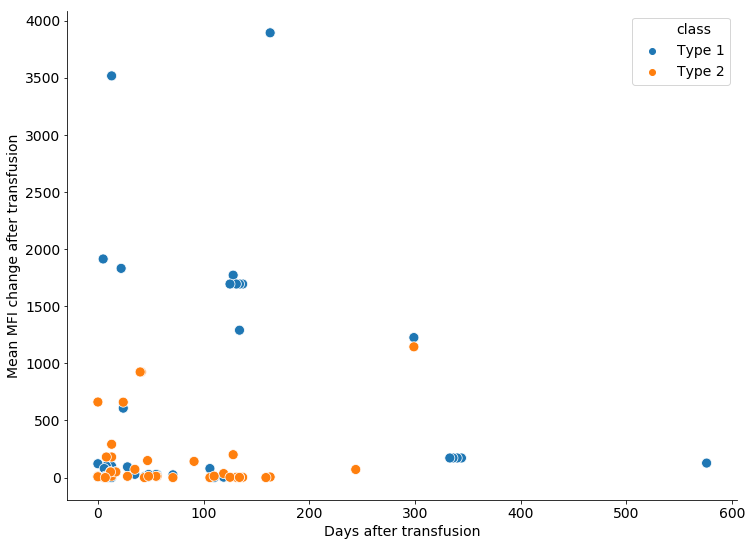

In [46]:
plt.rcParams.update({'font.size': 14})
fig, ax=plt.subplots(figsize=(12,9))
sns.scatterplot(data=transf_values[~transf_values['mean_mfi_change'].isna()],
                x='delta_t',y='mean_mfi_change', s=100, hue='class')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Days after transfusion')
ax.set_ylabel('Mean MFI change after transfusion')
plt.rcParams.update({'font.size': 11})

In [47]:
# 2 further analyses: (1) look at mean change over OTHER intervals and (2) single out patients above diagonal
# (1) 
def get_all_intervals(timeserie):
    return [(timeserie.index[i], timeserie.index[i+1]) for i in range(len(timeserie)-1)]

def get_matching_intervals(intervals, dates):
    matching_intervals_ids = []
    for d in dates:
        found = False
        for i, ints in enumerate(intervals):
            if d > ints[0] and d < ints[1]:
                matching_intervals_ids.append(i)
                found = True
                break
        if not found:
            matching_intervals_ids.append(-1)
    # Get the empty ones
    free_intervals_ids = []
    for j in range(len(intervals)):
        if j in set(matching_intervals_ids):
            continue
        else:
            free_intervals_ids.append(j)
    return matching_intervals_ids, free_intervals_ids

def add_values_with_non_transfused_mean(values, kept_ids, timeseries, class_type='Type 1'):
    for i, rs in enumerate(kept_ids):
        if rs in list(transfusion_dates_new.keys()):
            print(i)
#             print(rs)
            # Get general baseline
            intervals = get_all_intervals(timeseries[i])
            mean_changes = []
            for ints in intervals:
                x = timeseries[i].loc[ints[1]] - timeseries[i].loc[ints[0]]
                mean_changes.append(np.abs(x).T.mean(axis=0))
            baseline_mfi_variability = np.mean(mean_changes)
            # Get the ids of the non-transfused intervals
            non_transf_intervals_id = get_matching_intervals(intervals, 
                                                             transfusion_dates_new[rs])[1]
            print(non_transf_intervals_id)
            # If not empty, compute baseline change
            if non_transf_intervals_id:
                mean_changes = []
                for j in non_transf_intervals_id:
                    ints = intervals[j]
                    x = timeseries[i].loc[ints[1]] - timeseries[i].loc[ints[0]]
                    mean_changes.append(np.abs(x).T.mean(axis=0))
                baseline_mfi_variability_wo_transf = np.mean(mean_changes)
            else:
                baseline_mfi_variability_wo_transf = None
            for d in sorted(transfusion_dates_new[rs]):
                print("Transfusion date: {}".format(d))
                # Skip if the transfusion date is too old:
                if d < datetime.datetime(1995,1,1):
                    print("Date is too old, skipping.")
                    values.append([d, None, None, None, None, None, 
                                   baseline_mfi_variability, baseline_mfi_variability_wo_transf,
                                   class_type, rs, i])
                    continue

                # Skip if there are no subsequent dates.
                if (d > timeseries[i].index).all():
                    print("No subsequent dates.")
                    values.append([d, None, None, None, None, None, 
                                   baseline_mfi_variability, baseline_mfi_variability_wo_transf,
                                   class_type, rs, i])
                    continue

                # Find following date
                def func(bd):
                    delta = 0
                    delta =  bd - d if bd > d else timedelta.max
                    return delta
                next_date = min(timeseries[i].index[d <= timeseries[i].index], key = func)
                print("Following date: {}".format(next_date))

                # Get mean and max MFI
                mean_mfi = timeseries[i].loc[next_date].mean()
                max_mfi = timeseries[i].loc[next_date].max()

                dates = sorted(timeseries[i].index.tolist())
                index_next_date = dates.index(next_date)
                prev_date = dates[index_next_date-1] if index_next_date>0 else None

                if prev_date:
                    print("Previous date: {}".format(prev_date))
                    x = timeseries[i].loc[next_date] - timeseries[i].loc[prev_date]
                    mean_abs_mfi_change = np.abs(x).T.mean(axis=0)
                    max_abs_mfi_change = np.abs(x).T.max(axis=0)
                    values.append([d, (next_date-d).days, mean_mfi, max_mfi, 
                                   mean_abs_mfi_change, max_abs_mfi_change, 
                                   baseline_mfi_variability, baseline_mfi_variability_wo_transf,
                                   class_type, rs, i])
                else:
                    print("No previous date.")
                    values.append([d, (next_date-d).days, mean_mfi, max_mfi, 
                                   None, None, baseline_mfi_variability, baseline_mfi_variability_wo_transf,
                                   class_type, rs, i])
                # Get previous date

            print()
    return values


In [48]:
values = add_values_with_non_transfused_mean([], kept_ids, timeseries, class_type='Class I')
values = add_values_with_non_transfused_mean(values, kept_ids_2, timeseries_2, class_type='Class II')

7
[0, 1]
Transfusion date: 2014-04-11 00:00:00
No subsequent dates.

9
[0, 1, 2]
Transfusion date: 2013-10-03 00:00:00
No subsequent dates.
Transfusion date: 2013-10-06 00:00:00
No subsequent dates.

14
[0, 1]
Transfusion date: 2012-06-08 00:00:00
Following date: 2013-02-13 00:00:00
No previous date.
Transfusion date: 2012-06-25 00:00:00
Following date: 2013-02-13 00:00:00
No previous date.
Transfusion date: 2012-08-08 00:00:00
Following date: 2013-02-13 00:00:00
No previous date.

16
[0, 1, 2]
Transfusion date: 2015-07-15 00:00:00
No subsequent dates.

17
[0, 1]
Transfusion date: 2011-07-08 00:00:00
Following date: 2011-08-08 00:00:00
No previous date.

22
[0, 1, 2, 4, 5, 6, 7, 8]
Transfusion date: 2014-02-10 00:00:00
Following date: 2014-07-23 00:00:00
Previous date: 2014-01-13 00:00:00

24
[1, 2, 3, 4, 5, 6]
Transfusion date: 2013-11-29 00:00:00
Following date: 2013-12-12 00:00:00
Previous date: 2013-04-29 00:00:00
Transfusion date: 2013-12-04 00:00:00
Following date: 2013-12-12 00:

[0, 1]
Transfusion date: 2017-09-14 00:00:00
No subsequent dates.

429
[0, 1]
Transfusion date: 2016-10-19 00:00:00
Following date: 2017-01-18 00:00:00
No previous date.
Transfusion date: 2016-11-07 00:00:00
Following date: 2017-01-18 00:00:00
No previous date.

431
[1]
Transfusion date: 2016-10-25 00:00:00
Following date: 2017-03-08 00:00:00
Previous date: 2016-04-14 00:00:00

432
[0]
Transfusion date: 2016-02-10 00:00:00
Following date: 2017-02-02 00:00:00
No previous date.

433
[0, 1]
Transfusion date: 2017-08-29 00:00:00
No subsequent dates.

434
[0]
Transfusion date: 2016-02-26 00:00:00
Following date: 2016-12-14 00:00:00
No previous date.

7
[0, 1, 2, 3, 4]
Transfusion date: 2014-04-11 00:00:00
No subsequent dates.

13
[0, 1]
Transfusion date: 2012-06-08 00:00:00
Following date: 2013-02-13 00:00:00
No previous date.
Transfusion date: 2012-06-25 00:00:00
Following date: 2013-02-13 00:00:00
No previous date.
Transfusion date: 2012-08-08 00:00:00
Following date: 2013-02-13 00:00:00


268
[0, 1, 2]
Transfusion date: 2016-03-29 00:00:00
No subsequent dates.
Transfusion date: 2016-04-07 00:00:00
No subsequent dates.

274
[0, 1]
Transfusion date: 2017-01-09 00:00:00
No subsequent dates.

276
[1, 2, 3]
Transfusion date: 1201-11-12 00:00:00
Date is too old, skipping.
Transfusion date: 2014-04-23 00:00:00
Following date: 2014-08-11 00:00:00
Previous date: 2013-07-26 00:00:00

281
[0, 1]
Transfusion date: 2014-08-28 00:00:00
No subsequent dates.

288
[]
Transfusion date: 2014-02-24 00:00:00
Following date: 2014-03-31 00:00:00
Previous date: 2013-10-10 00:00:00
Transfusion date: 2014-04-11 00:00:00
No subsequent dates.
Transfusion date: 2014-04-16 00:00:00
No subsequent dates.
Transfusion date: 2014-04-16 00:00:00
No subsequent dates.

294
[0, 1, 2, 5, 6, 7, 8]
Transfusion date: 2013-08-14 00:00:00
Following date: 2013-08-27 00:00:00
Previous date: 2013-08-08 00:00:00
Transfusion date: 2013-09-25 00:00:00
Following date: 2013-10-23 00:00:00
Previous date: 2013-08-27 00:00:0

In [49]:
transf_values_ext = pd.DataFrame(values, columns=['transf_date','delta_t', 'mean_mfi', 'max_mfi', 
                                              'mean_mfi_change', 'max_mfi_change','patient_average_mfi_change',
                                                  'patient_average_mfi_change_wo_transfusion',
                                                  'Class', 'rs', 'id'])

In [50]:
cubehelix_pal = sns.cubehelix_palette(5, start=.3, rot=-.8, gamma=0.6, hue=0.95, light=0.8, dark=0.1)

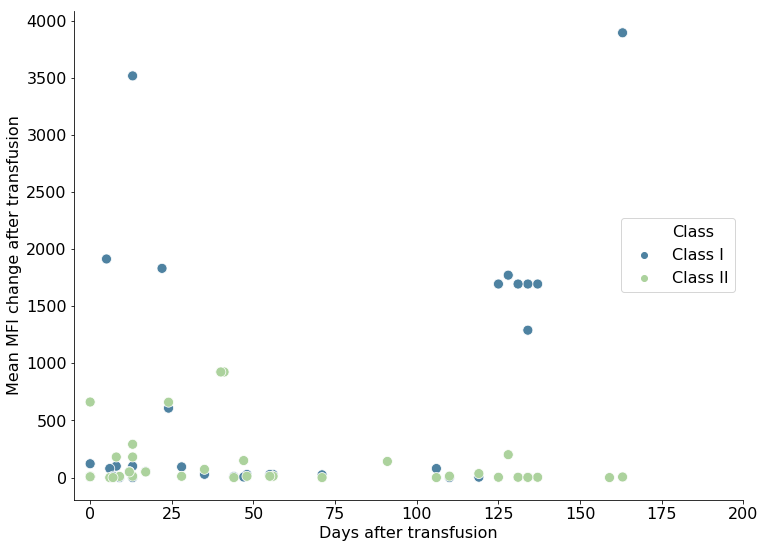

In [51]:
plt.rcParams.update({'font.size': 16})
fig, ax=plt.subplots(figsize=(12,9))
transf_values_ext['ratio']=transf_values_ext['mean_mfi_change']/transf_values_ext['patient_average_mfi_change_wo_transfusion']
sns.scatterplot(data=transf_values_ext[~transf_values_ext['mean_mfi_change'].isna()],
                x='delta_t',y='mean_mfi_change', s=100, hue='Class', 
               palette={'Class II': cubehelix_pal[1], 'Class I': cubehelix_pal[-2]})
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Days after transfusion')
ax.set_xlim(-5,200)
ax.set_ylabel('Mean MFI change after transfusion')
plt.rcParams.update({'font.size': 11})
plt.savefig('paper/figures/supplementary/transfusion_analysis.png', dpi=300, bbox_inches='tight')
plt.savefig('paper/figures/supplementary/transfusion_analysis.pdf', dpi=300, bbox_inches='tight')